In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import os
os.chdir('/content/drive/MyDrive/')

## Data preparing

In [25]:
data = pd.read_csv('final_data.csv')

In [26]:
data.drop('Unnamed: 0' ,axis=1, inplace=True)

In [27]:
data.head()

,Year,Month,Day,Hour,Air pressure,Air temperature,RAD radiation,Precipitation,Realtive humidity,UVB radiation,CO,NO2,NOx,O3,PM2.5,PM10,SO2,C6H6
0,2015,1,1,0,1012.0,-6.6,0.0,62.8,1.6,278.0,0.575,18.0,20.0,7.0,19.0,NaN,35.778146,5.01000
1,2015,1,1,1,1011.0,-7.4,0.0,69.6,1.5,279.0,0.581,20.0,25.0,7.0,13.0,50.0,244.272000,5.25388
2,2015,1,1,2,1011.0,-7.1,0.0,72.3,1.4,286.0,0.678,20.0,25.0,6.0,11.0,34.0,102.633000,4.74133
3,2015,1,1,3,1012.0,-6.5,0.2,71.0,1.5,292.0,0.686,21.0,24.0,6.0,9.0,29.0,77.725900,4.66580
4,2015,1,1,4,1012.0,-5.6,0.0,69.2,1.7,299.0,0.653,22.0,25.0,6.0,10.0,21.0,69.562100,4.77038


In [28]:
def prepare_data(data):
  #Preparing dataset for model
  data2015 = data[data.Year==2015]
  data_2015_by_day = data2015.groupby(['Month','Day']).mean()
  data_2015_by_day.reset_index(drop=True, inplace=True)
  data_2015_by_day.reset_index(drop=True, inplace=True)
  data_2015_by_day = data_2015_by_day['NOx']
  data2016 = data[data.Year==2016]
  data_2016_by_day = data2016.groupby(['Month','Day']).mean()
  data_2016_by_day.reset_index(drop=True, inplace=True)
  data_2016_by_day.reset_index(drop=True, inplace=True)
  data_2016_by_day = data_2016_by_day['NOx']
  data2017 = data[data.Year==2017]
  data_2017_by_day = data2017.groupby(['Month','Day']).mean()
  data_2017_by_day.reset_index(drop=True, inplace=True)
  data_2017_by_day.reset_index(drop=True, inplace=True)
  data_2017_by_day = data_2017_by_day['NOx']
  combine = [data_2015_by_day,data_2016_by_day,data_2017_by_day]
  data = pd.concat(combine)
  return data

In [29]:
data = prepare_data(data)

In [30]:
data.reset_index(drop=True, inplace=True)

In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Train, test split

In [32]:
train, test = data[0:728], data[728:1092]

## Model build

In [33]:
window_size=7

In [34]:
windowed_train = windowed_dataset(train, window_size, 10, 1096)

In [35]:
model = Sequential()
model.add(Dense(1, input_shape = [window_size]))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
model.fit(windowed_train, epochs=100, verbose=0)

In [36]:
model.get_weights()

[array([[ 0.11917389],
        [ 0.0177602 ],
        [ 0.08367626],
        [ 0.06898766],
        [ 0.06991291],
        [-0.04000133],
        [ 0.57418555]], dtype=float32), array([1.8775065], dtype=float32)]

## Simple forecast

In [37]:
forecast = []

for time in range(len(data)- window_size):
  forecast.append(model.predict(data.values[time:time + window_size][np.newaxis]))

forecast = forecast[728-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(14,7))

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

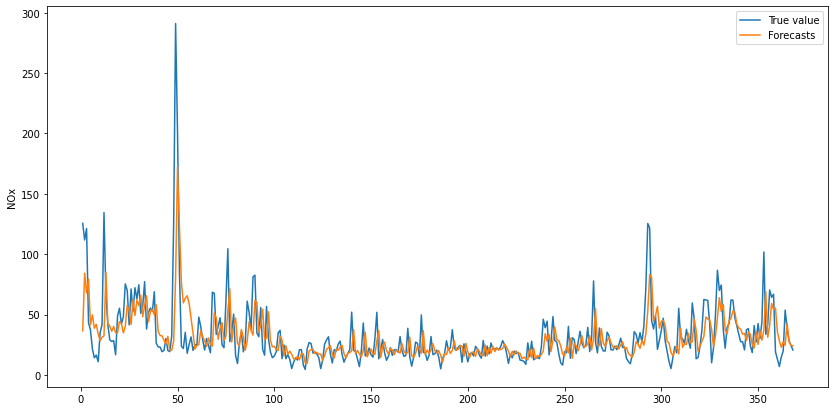

In [38]:
plt.figure(figsize=(14,7))

timestamp = np.arange(1, len(data[728:])+1)
ax = sns.lineplot(timestamp , data[728:], label = 'True value')
ax1 = sns.lineplot(timestamp, results, label = 'Forecasts')

plt.show()

In [39]:
print('Annual RMSE: {}'.format(np.sqrt(mean_squared_error(data[728:], results))))
print('Annual MAE: {}'.format(mean_absolute_error(data[728:], results)))

Annual RMSE: 21.486511423706972
Annual MAE: 12.812560540154498
